In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow import keras
np.random.seed(0)
import tensorflow as tf
import nltk
tf.random.set_seed(1)
import joblib

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding='latin1')
test = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv', encoding='latin1')

df = pd.concat([train, test])
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44955 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       44955 non-null  int64 
 1   ScreenName     44955 non-null  int64 
 2   Location       35531 non-null  object
 3   TweetAt        44955 non-null  object
 4   OriginalTweet  44955 non-null  object
 5   Sentiment      44955 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.4+ MB


In [4]:
df.drop(['UserName', 'ScreenName', 'Location', 'TweetAt'], axis=1, inplace=True)
df

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...
3793,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,Did you panic buy a lot of non-perishable item...,Negative
3795,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,Gov need to do somethings instead of biar je r...,Extremely Negative


In [5]:
df.drop_duplicates(inplace=True)
df

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...
3793,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,Did you panic buy a lot of non-perishable item...,Negative
3795,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,Gov need to do somethings instead of biar je r...,Extremely Negative


<Axes: xlabel='Sentiment', ylabel='count'>

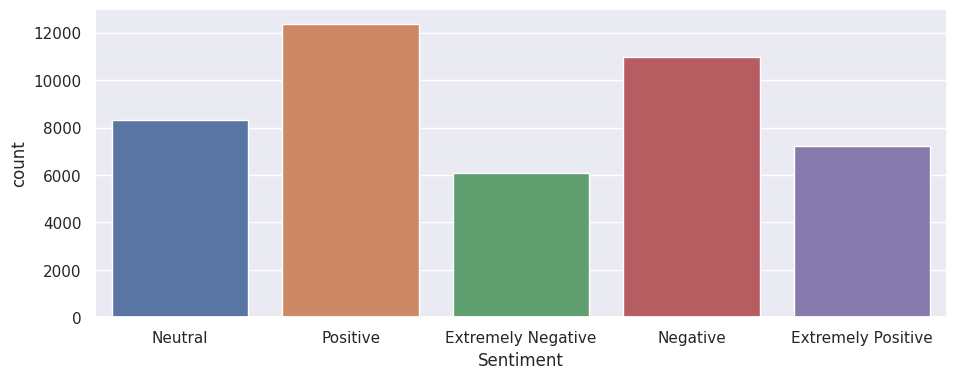

In [6]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(11,4)})
sns.countplot(x='Sentiment', data=df)

In [7]:
df['Sentiment'].value_counts()

Sentiment
Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: count, dtype: int64

In [8]:
df.replace(['Extremely Negative', 'Extremely Positive','Extremely Pos'], ['Negative', 'Positive','Positive'], inplace=True)
df['Sentiment'].value_counts()

Sentiment
Positive    19592
Negative    17031
Neutral      8332
Name: count, dtype: int64

In [11]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
import re
import nltk
nltk.download('punkt') # At first you have to download these nltk packages.
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = stopwords.words('english') # defining stop_words
stop_words.remove('not') # removing not from the stop_words list as it contains value in negative movies
lemmatizer = WordNetLemmatizer()

def nlpPreprocessing(tweet):
    # Data cleaning
    tweet = re.sub(r'@\w+', '', tweet)  # Remove mentions
    tweet = re.sub(r'#\w+', '', tweet)  # Remove hashtags
    tweet = re.sub(r'https?://\S+|www\.\S+', '', tweet)  # Remove URLs
    tweet = re.sub(r'<.*?>', '', tweet)  # Remove HTML tags
    tweet = re.sub('[^A-Za-z]+', ' ', tweet)  # Keep only alphabetic characters

    # Convert to lowercase
    tweet = tweet.lower()

    # Tokenization
    tokens = nltk.word_tokenize(tweet)  # Convert text to tokens

    # Remove single-character tokens (except meaningful ones like 'i' and 'a')
    tokens = [word for word in tokens if len(word) > 1]

    # Remove stopwords
    tweet = [word for word in tokens if word not in stop_words]

    # Lemmatization
    tweet = [lemmatizer.lemmatize(word) for word in tweet]

    # Join words back into a single string
    tweet = ' '.join(tweet)

    return tweet

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
 !unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [15]:
df['OriginalTweet'] = df['OriginalTweet'].apply(nlpPreprocessing)
df.head()

,OriginalTweet,Sentiment
0,,Neutral
1,advice talk neighbour family exchange phone nu...,Positive
2,coronavirus australia woolworth give elderly d...,Positive
3,food stock not one empty please panic enough f...,Positive
4,ready go supermarket outbreak not paranoid foo...,Negative


In [16]:
df['Sentiment'] = df['Sentiment'].apply(lambda x: x.lower())
df.head()

,OriginalTweet,Sentiment
0,,neutral
1,advice talk neighbour family exchange phone nu...,positive
2,coronavirus australia woolworth give elderly d...,positive
3,food stock not one empty please panic enough f...,positive
4,ready go supermarket outbreak not paranoid foo...,negative


In [17]:
!pip install WordCloud

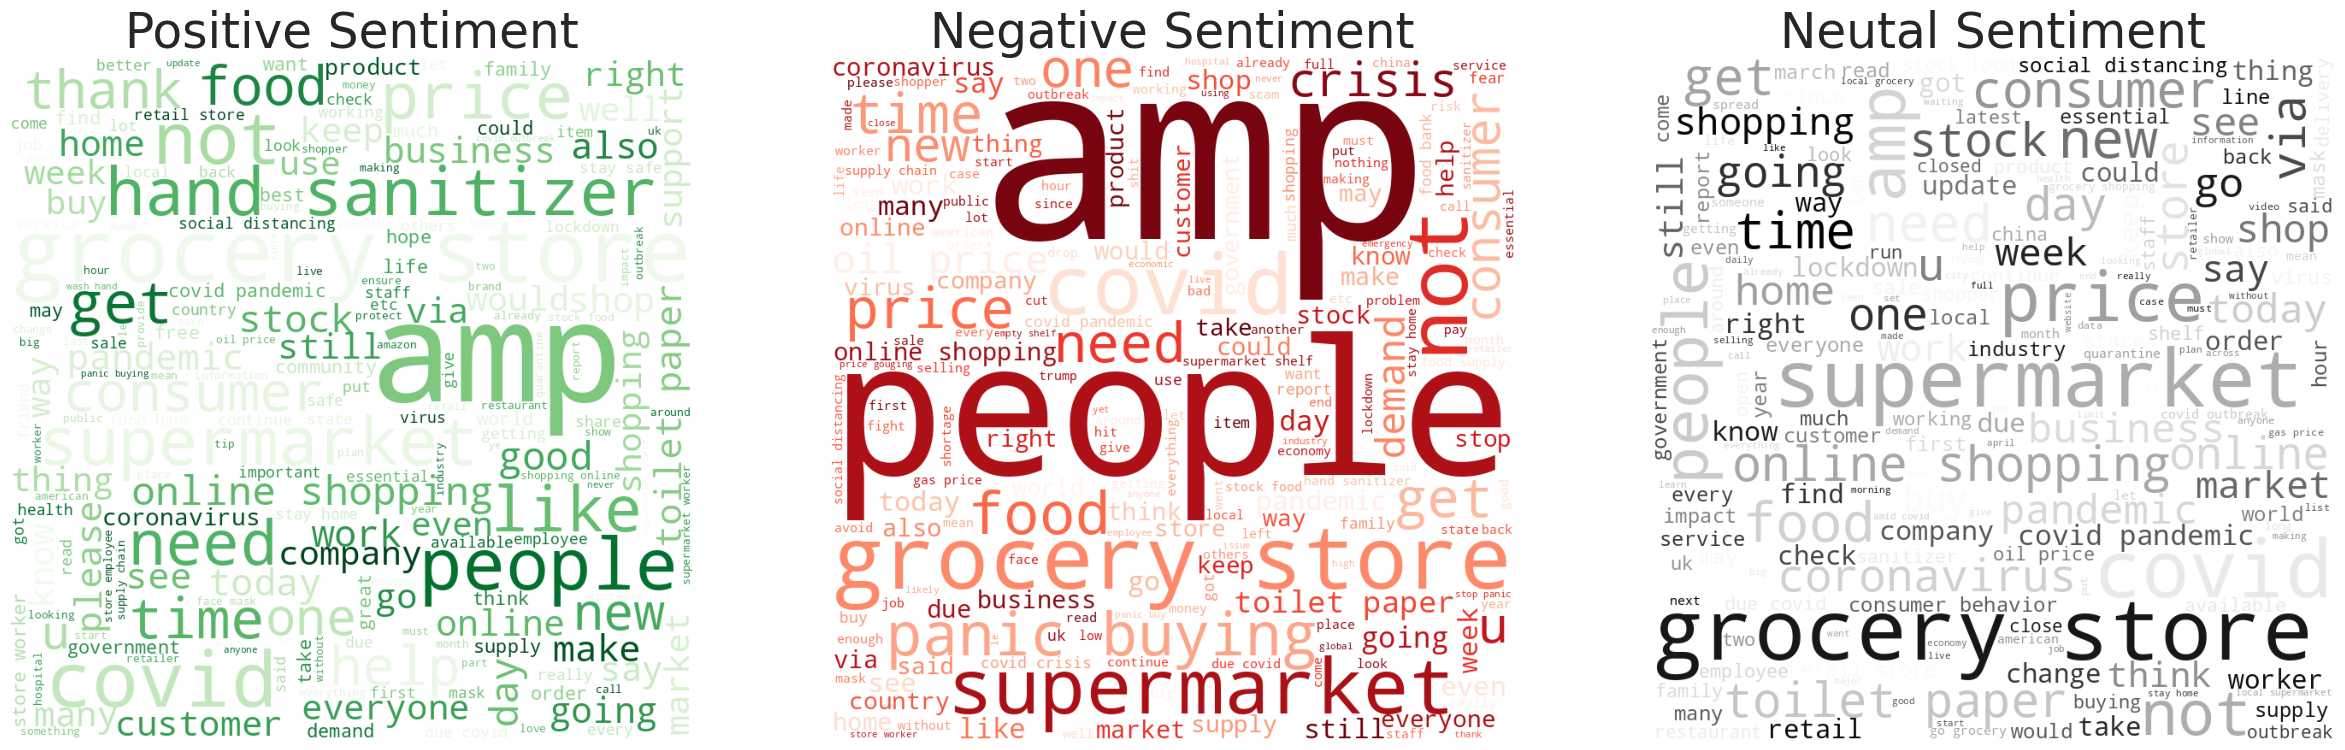

In [18]:
from wordcloud import WordCloud
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 15])

df_pos = df[df["Sentiment"]=="positive"]['OriginalTweet']
df_neg = df[df["Sentiment"]=="negative"]['OriginalTweet']
df_neu = df[df["Sentiment"]=="neutral"]['OriginalTweet']

words_list = df_pos.unique().tolist()
words = " ".join(words_list)


wordcloud1 = WordCloud(width = 800, height = 800,
                background_color ='white',
                colormap="Greens",
                stopwords = stop_words,
                min_font_size = 10).generate(words)

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive Sentiment',fontsize=35);

words_list = df_neg.unique().tolist()
words = " ".join(words_list)


wordcloud2 = WordCloud(width = 800, height = 800,
                background_color ='white',
                colormap="Reds",
                stopwords = stop_words,
                min_font_size = 10).generate(words)
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative Sentiment',fontsize=35);

words_list = df_neu.unique().tolist()
words = " ".join(words_list)


wordcloud3 = WordCloud(width = 800, height = 800,
                background_color ='white',
                colormap="Greys",
                stopwords = stop_words,
                min_font_size = 10).generate(words)
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Neutal Sentiment',fontsize=35);

In [19]:
l = {"neutral":0, "positive":1,"negative":2}
df['Sentiment'] = df['Sentiment'].map(l)
df

,OriginalTweet,Sentiment
0,,0
1,advice talk neighbour family exchange phone nu...,1
2,coronavirus australia woolworth give elderly d...,1
3,food stock not one empty please panic enough f...,1
4,ready go supermarket outbreak not paranoid foo...,2
...,...,...
3793,meanwhile supermarket israel people dance sing...,1
3794,panic buy lot non perishable item echo need fo...,2
3795,asst prof economics talking recent research co...,0
3796,gov need somethings instead biar je rakyat ass...,2


In [20]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

x = df['OriginalTweet']
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y)

y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [21]:
from gensim.models import Word2Vec
tweets = X_train.tolist()
tweets = [tweet.split() for tweet in tweets]
w2v = Word2Vec(tweets, vector_size=200, window=5, workers=7, epochs=100, min_count=5)

In [22]:
print(w2v.wv.most_similar('pay'))

[('paying', 0.44653454422950745), ('paid', 0.40365996956825256), ('salary', 0.31325462460517883), ('benefit', 0.30162522196769714), ('tax', 0.27716076374053955), ('med', 0.27690619230270386), ('qualify', 0.2768986225128174), ('rent', 0.2757661044597626), ('expense', 0.2724604606628418), ('laid', 0.27153533697128296)]


In [23]:
print(w2v.wv.most_similar('covid'))

[('coronavirus', 0.6114231944084167), ('consumer', 0.3195479214191437), ('global', 0.3194831907749176), ('virus', 0.29737019538879395), ('help', 0.28336822986602783), ('negatively', 0.2611289620399475), ('may', 0.25492987036705017), ('likely', 0.25344377756118774), ('business', 0.2516496777534485), ('corona', 0.2491115778684616)]


In [24]:
w2v.wv.doesnt_match(['grocery', 'covid', 'coronavirus'])

'grocery'

In [25]:
max_len = np.max(X_train.apply(lambda x :len(x)))
max_len

261

In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#creating embedding matrix

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_length = len(tokenizer.word_index) + 1


X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

print(vocab_length)

embedding_dim = 200
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in w2v.wv:
        embedding_matrix[i] = w2v.wv[word]


25188


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout,GlobalMaxPooling1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
# Define the model
model = Sequential()

# Embedding layer with the pre-trained Word2Vec weights
model.add(Embedding(input_dim=vocab_length,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_len,  # max length of input sequences
                    trainable=False))


model.add(Bidirectional(LSTM(264, return_sequences=True, kernel_regularizer=l2(0.0002))))

model.add(Dropout(0.3))

model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.0002))))

model.add(Dropout(0.3))

model.add(GlobalMaxPooling1D())

model.add(Dense(128, activation='relu'))

model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))

model.add(Dropout(0.2))

model.add(Dense(3, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy'  , metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     5,037,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,037,600 (19.22 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,037,600 (19.22 MB)

In [28]:
num_epochs = 10
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 78s 72ms/step - accuracy: 0.6408 - loss: 1.0301 - val_accuracy: 0.7826 - val_loss: 0.7089
Epoch 2/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 73s 74ms/step - accuracy: 0.7994 - loss: 0.6716 - val_accuracy: 0.8102 - val_loss: 0.6470
Epoch 3/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 73s 74ms/step - accuracy: 0.8369 - loss: 0.5912 - val_accuracy: 0.8217 - val_loss: 0.6552
Epoch 4/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 73s 74ms/step - accuracy: 0.8553 - loss: 0.5651 - val_accuracy: 0.8218 - val_loss: 0.6846
Epoch 5/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 73s 74ms/step - accuracy: 0.8742 - loss: 0.5392 - val_accuracy: 0.8227 - val_loss: 0.7551


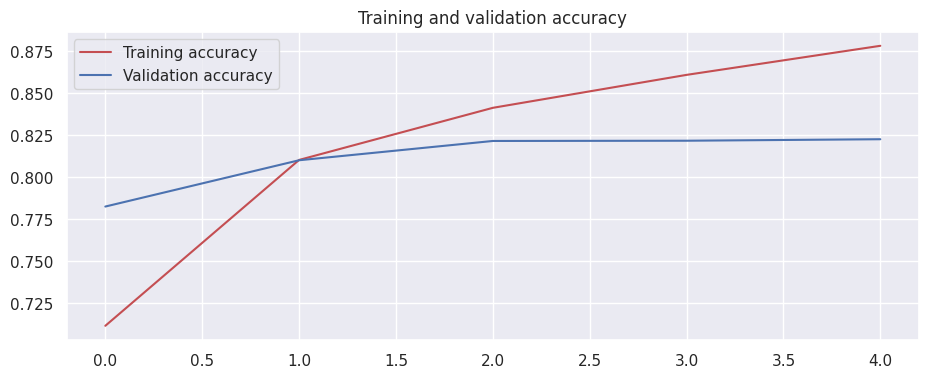

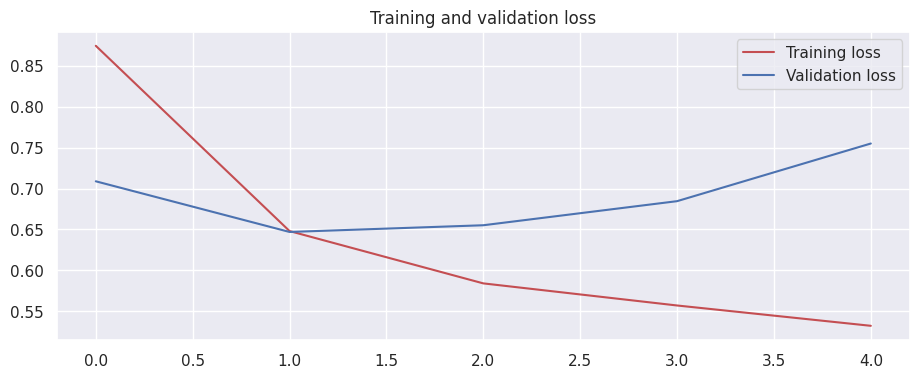

Accuracy on training data is:- 87.83844113349915 %
Loss 53.21686863899231
Accuracy on validation data is:- 82.27181434631348 %
Loss 75.5144715309143


In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

print(f"Accuracy on training data is:- {acc[-1]*100} %")
print(f"Loss {loss[-1]*100}")

print(f"Accuracy on validation data is:- {val_acc[-1]*100} %")
print(f"Loss {val_loss[-1]*100}")

In [30]:
model.save("COVID_NLP4.keras")

In [31]:

joblib.dump(tokenizer, 'tokenizer4.joblib')

['tokenizer4.joblib']

In [32]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import joblib
# Load the model
model = load_model('/kaggle/working/COVID_NLP4.keras')
# Load the model from the specified file
tokenizer = joblib.load('/kaggle/working/tokenizer4.joblib')

# X_test = tokenizer.texts_to_sequences(X_test)
# X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.8097 - loss: 0.6414
Test Loss: 0.6469503045082092
Test Accuracy: 0.810187578201294


## Allow the embedding layer to modify the word2vec weights 

In [33]:
# Define the model
model = Sequential()

# Embedding layer with the pre-trained Word2Vec weights
model.add(Embedding(input_dim=vocab_length,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_len,  # max length of input sequences
                    trainable=True))


model.add(Bidirectional(LSTM(264, return_sequences=True, kernel_regularizer=l2(0.0002))))

model.add(Dropout(0.3))

model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.0002))))

model.add(Dropout(0.3))

model.add(GlobalMaxPooling1D())

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001)))

model.add(Dropout(0.3))

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001)))

model.add(Dropout(0.3))

model.add(Dense(3, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy'  , metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     5,037,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,037,600 (19.22 MB)

 Trainable params: 5,037,600 (19.22 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
num_epochs = 10
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 82s 79ms/step - accuracy: 0.6470 - loss: 1.0604 - val_accuracy: 0.8119 - val_loss: 0.6682
Epoch 2/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 77s 78ms/step - accuracy: 0.8343 - loss: 0.6125 - val_accuracy: 0.8368 - val_loss: 0.5985
Epoch 3/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 77s 78ms/step - accuracy: 0.8848 - loss: 0.4719 - val_accuracy: 0.8458 - val_loss: 0.5969
Epoch 4/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 77s 78ms/step - accuracy: 0.9181 - loss: 0.3816 - val_accuracy: 0.8473 - val_loss: 0.6208
Epoch 5/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 77s 78ms/step - accuracy: 0.9379 - loss: 0.3190 - val_accuracy: 0.8491 - val_loss: 0.6090
Epoch 6/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 77s 78ms/step - accuracy: 0.9501 - loss: 0.2874 - val_accuracy: 0.8475 - val_loss: 0.6658


In [35]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.8457 - loss: 0.5938
Test Loss: 0.596936821937561
Test Accuracy: 0.8457773923873901


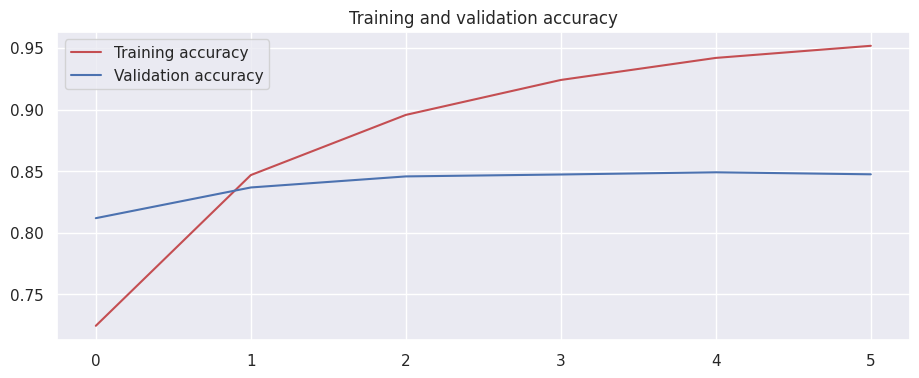

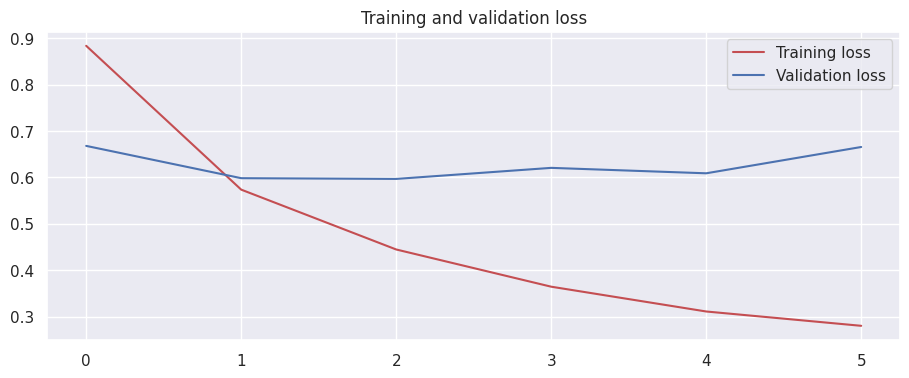

Accuracy on training data is:- 95.17287611961365 %
Loss 28.011226654052734
Accuracy on validation data is:- 84.74827408790588 %
Loss 66.57688617706299


In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

print(f"Accuracy on training data is:- {acc[-1]*100} %")
print(f"Loss {loss[-1]*100}")

print(f"Accuracy on validation data is:- {val_acc[-1]*100} %")
print(f"Loss {val_loss[-1]*100}")

In [37]:
model.save("COVID_NLP5.keras")

In [38]:
joblib.dump(tokenizer, 'tokenizer5.joblib')

['tokenizer5.joblib']